In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

<h3>VARIABLES</h3>

In [2]:
IMG_SHAPE = (300,300,3)
LR = 0.0001
EPOCHS = 10
BATCH_SIZE=21

<h3>Load Data</h3>

In [3]:
(ds_train, ds_test)= tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    batch_size=BATCH_SIZE
    
)

<h3>Model Setup</h3>

In [4]:
# Augmentation layer because of small dataset

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [5]:
# MobileNet bottom layers with ImageNet weights

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [6]:
# Create Model

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # Rescale inputs to [-1,1] from 0-255
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [7]:
# Compile model

model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 300, 300, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 300, 300, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

<h3>Fit data and Plot results</h3>

In [9]:
history = model.fit(ds_train,
                    epochs=EPOCHS,
                    validation_data=ds_test)

Epoch 1/10
120/120 [==============================] - 102s 851ms/step - loss: 1.1865 - accuracy: 0.3536 - val_loss: 0.9964 - val_accuracy: 0.4919
Epoch 2/10
120/120 [==============================] - 105s 878ms/step - loss: 0.9517 - accuracy: 0.5325 - val_loss: 0.8424 - val_accuracy: 0.7070
Epoch 3/10
120/120 [==============================] - 106s 885ms/step - loss: 0.7862 - accuracy: 0.6690 - val_loss: 0.7366 - val_accuracy: 0.7392
Epoch 4/10
120/120 [==============================] - 98s 815ms/step - loss: 0.6826 - accuracy: 0.7512 - val_loss: 0.6555 - val_accuracy: 0.7930
Epoch 5/10
120/120 [==============================] - 94s 786ms/step - loss: 0.5869 - accuracy: 0.8282 - val_loss: 0.5982 - val_accuracy: 0.8145
Epoch 6/10
120/120 [==============================] - 96s 801ms/step - loss: 0.5160 - accuracy: 0.8587 - val_loss: 0.5457 - val_accuracy: 0.8387
Epoch 7/10
120/120 [==============================] - 97s 812ms/step - loss: 0.4722 - accuracy: 0.8794 - val_loss: 0.5102 - val

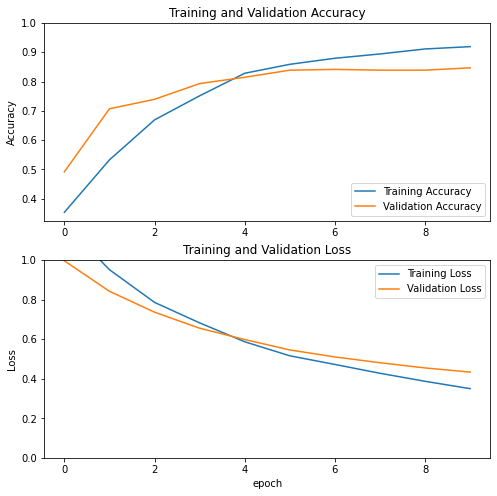

In [10]:
# Plot Loss and Accuracy for Taining and Validation data

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<h3>Save Model</h3>

In [12]:
# Path to directory
path = './public/model/'
model_path = path + 'model.h5'

# Save Model
model.save(model_path)

# Convert for Tensorflow.js
!tensorflowjs_converter --input_format=keras {model_path} {path}